# Hook Practice

- How to register a hook at targeted layer of network
- http://pytorch.org/docs/0.3.1/autograd.html?highlight=register_hook#torch.autograd.Variable.register_hook

## 1) Import required Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  

import random

## 2) Hyperparameters

In [2]:
batch_size = 128
learning_rate = 0.0001
num_epoch = 10

In [3]:
# padding 16
def one_sided_padding(x):
    rand1 = random.randrange(0,15,7)
    rand2 = random.randrange(0,15,7)
    #rand1 = 15
    #rand2 = 15
    
    zero = np.zeros(shape=[28,28,1])
    
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

## 3) Dataloader

In [4]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            #transforms.Pad(8),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            #transforms.Pad(8),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

## 4) Define Class

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )       
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)

        return out

model = CNN().cuda()

## 5) Loss & Optimizer

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 6) Train

In [7]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    model.eval()    
        
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break

Test Data Accuracy: [93.84015]
Test Data Accuracy: [95.85336]
Test Data Accuracy: [96.394226]
Test Data Accuracy: [96.96515]
Test Data Accuracy: [97.546074]
Test Data Accuracy: [97.64624]
Test Data Accuracy: [97.50601]
Test Data Accuracy: [98.006805]


## 7) Register Hook

In [8]:
grad_out = []
def hook(module,grad_input,grad_output):
    #print("grad_input: {}\ngrad_output: {}".format(grad_input[0].data.size(),grad_output[0].data.size()))
    grad_out.append(grad_output[0].data)
    
def visualize(cam_img,img_var):
    x = img_var[0,:,:].cpu().data.numpy()
    
    plt.subplot(1,3,1)
    plt.imshow(cam_img)

    plt.subplot(1,3,2)
    plt.imshow(x,cmap="gray")

    plt.subplot(1,3,3)
    plt.imshow(x+cam_img)
    plt.show()

0 0
Grad Out Length 1


/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


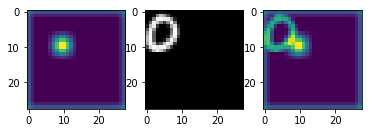

0 8
Grad Out Length 2


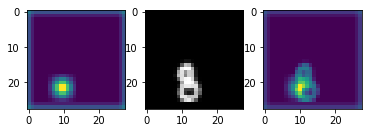

0 7
Grad Out Length 3


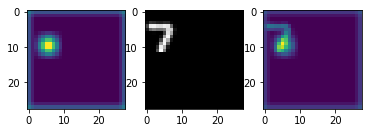

0 0
Grad Out Length 4


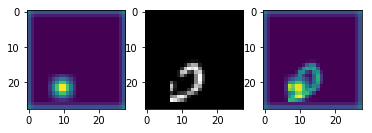

0 4
Grad Out Length 5


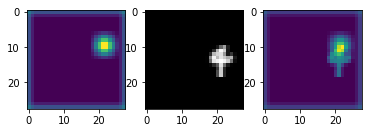

0 9
Grad Out Length 6


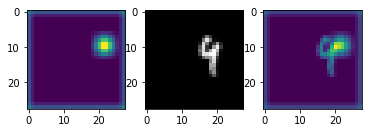

0 0
Grad Out Length 7


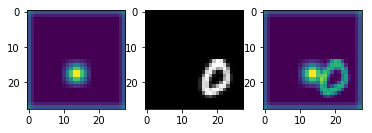

0 7
Grad Out Length 8


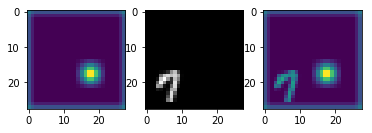

0 7
Grad Out Length 9


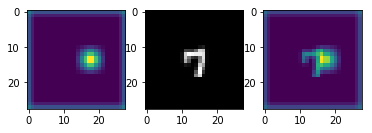

0 8
Grad Out Length 10


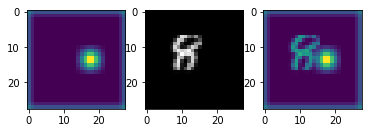

0 8
Grad Out Length 11


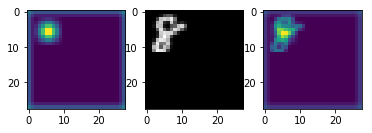

In [9]:
# i 번째 입력값, lab는 해당 라벨

i=0
for j,[image,label] in enumerate(test_loader):
    h = model.layer[-1].register_backward_hook(hook)

    x = Variable(image).cuda()
    y_= Variable(label).cuda()

    lab = y_[i].cpu().data[0]
    print(i,lab)

    optimizer.zero_grad()
    output = model.forward(x)

    output[i,lab].backward(retain_graph=True)
    
    print("Grad Out Length",len(grad_out))

    alpha = torch.sum(torch.sum(grad_out[j],dim=3,keepdim=True),dim=2,keepdim=True)

    cam = alpha[i]*grad_out[j][i]

    cam = torch.sum(cam,dim=0)
    cam = 2*(cam-torch.min(cam))/(torch.max(cam)-torch.min(cam))-1
    #cam = torch.clamp(cam,min=-1,max=1)
    cam[cam<torch.max(cam)]=-1
        
    img = resize(cam.cpu().numpy(),output_shape=(28,28))

    visualize(img,x[i])

    h.remove()
    
    if j ==10:
        break